In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import tensorflow as tf
from pprint import pprint

In [2]:
# df = pd.read_csv('total3.csv')
# df = pd.read_csv('lsi.csv')
# df = pd.read_csv('w2v.csv')
df = pd.read_csv('w2v_crnn.csv')

In [76]:
dd = df.as_matrix()
dd = dd.flatten()

print(len(dd))

for idx, el in enumerate(dd):
    if type(el) is not str and el>0:
        dd[idx] = 1
        
dd2 = dd.reshape(df.shape[0], df.shape[1])

df2 = pd.DataFrame(dd2, columns=df.columns)
df2.head()

3696875


,600,601,602,603,604,605,606,607,608,609,...,3115,3116,3117,3118,3119,3120,3121,3122,3123,y
0,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
2,1,1,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
3,1,1,1,0,0,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,1,0


In [77]:
df = df2

In [3]:
df.drop(["macaddr"], axis=1, inplace=True)

In [4]:
df.head()

,w2v0,w2v1,w2v2,w2v3,w2v4,w2v5,w2v6,w2v7,w2v8,w2v9,...,w2v14967,w2v14968,w2v14969,w2v14970,w2v14971,w2v14972,w2v14973,w2v14974,w2v14975,y
0,-2.384552,-1.645188,-1.424754,-1.424754,-0.409321,-1.786392,-0.946850,-0.409321,-1.645188,-1.559639,...,0.874261,0.689394,0.689394,0.689394,0.689394,0.874261,0.874261,0.874261,0.281711,0
1,-1.923601,-1.559639,-1.559639,-1.559639,-1.559639,-1.559639,-1.559639,-1.746532,-1.559639,-1.424754,...,-0.228268,0.281711,0.281711,-0.329901,-0.228268,0.281711,-1.620165,-0.564668,0.281711,0
2,-1.793147,-1.793147,-1.793147,-0.946850,-1.381054,0.462345,-1.793147,-1.793147,-1.559639,-3.229192,...,0.915534,0.281711,-0.094003,-0.939172,-0.094003,-0.329901,0.281711,-1.511598,-0.329901,0
3,-1.546335,-1.746532,-1.793147,-3.564994,-1.559639,-1.645188,-0.349660,-2.384552,-1.559639,-0.946850,...,-1.803935,-0.228268,-0.950503,-0.229437,0.281711,0.281711,-1.620165,-1.214719,0.281711,0
4,-1.776325,-1.559639,-1.559639,-1.559639,-1.559639,-1.559639,-1.559639,-1.559639,-2.071387,-2.071387,...,0.281711,-0.513839,1.048756,0.281711,0.281711,0.281711,0.281711,0.281711,-1.821718,0


In [5]:
X = df.drop(['y'], axis=1)
Y = df['y']

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

{0, 1}


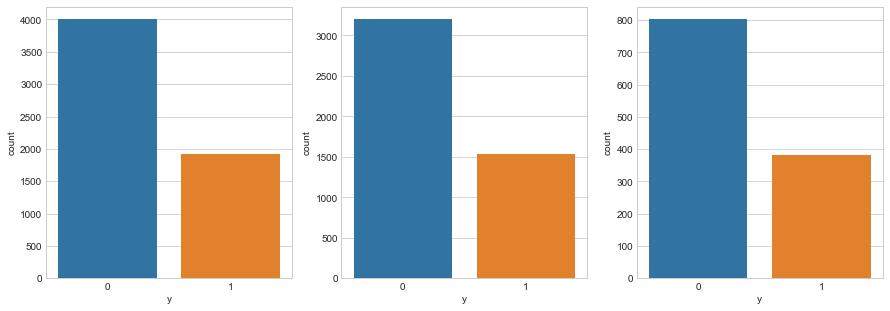

In [7]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x=Y, ax=axis1)
sns.countplot(x=Y_train, ax=axis2)
sns.countplot(x=Y_test, ax=axis3)
print(set(Y))

In [8]:
# 피처 데이터, 레이블, 미니배치 갯수
def getMiniBatch(df_, y, n):
    if len(df_) != len(y):
        print('Feature and label num is not equal.')
        return
    start = 0
    while True:
        if start>= len(df_):
#             셔플을 안하니까 좀 되네...
#             df_ = df_.sample(frac=1).reset_index(drop=True) # 1epoch 이후 셔플
            start = 0
#         print(start)
        yield df_[start: start+n], y[start: start+n]
        start += n 

In [84]:
set([type(i) for i in Y_test])
# df.shape

{numpy.int64}

In [9]:
sess = tf.InteractiveSession()
Y_train = sess.run(tf.one_hot(Y_train, 2))
Y_test = sess.run(tf.one_hot(Y_test, 2))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4732, 14976) (4732, 2) (1183, 14976) (1183, 2)


---
## 이건 CRNN

In [23]:
L1_flat
L1
# 22*32*50

<tf.Tensor 'Relu:0' shape=(?, 22, 1, 32) dtype=float32>

In [34]:
tf.reset_default_graph()
tf.set_random_seed(777)  # reproducibility

# hyper parameters
learning_rate = 0.001
batch_size = 50
epoch = 200

# input place holders
X = tf.placeholder(tf.float32, [None, 26*24*24])
Y = tf.placeholder(tf.float32, [None, 2])
# X_img = tf.reshape(X, [-1, 26, 24, 24])   # img dsy*hour*w2v
X_img = tf.reshape(X, [-1, 24, 24, 26])   # img hour*w2v*day(channel)

# ============== cnn
# L1 ImgIn shape=(?, 24, 24, 26)
W1 = tf.Variable(tf.random_normal([3, 24, 26, 26], stddev=0.01))
#    Conv     -> (?, 26, 1, 32)
#    Pool     -> (?, 13, 12, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='VALID')
L1 = tf.nn.relu(L1)

# L1_flat = tf.reshape(L1, [-1, 24 * (24-2) * 26])

# # Final FC 7x6x64 inputs -> 2 outputs
# W3 = tf.get_variable("W3", shape=[24*(24-2)*32, 100],
#                      initializer=tf.contrib.layers.xavier_initializer())
# b = tf.Variable(tf.random_normal([100]))
# RPR = tf.matmul(L1_flat, W3)+b


seq_length = 26
data_dim = 24-2
hidden_dim = data_dim
output_dim = 2

X_re = tf.reshape(L1, [-1, seq_length, data_dim])
# =============== rnn toss
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)#, activation=tf.nn.relu)
cell = tf.contrib.rnn.MultiRNNCell([cell]*2, state_is_tuple=True) # multiple layers
outputs, _states = tf.nn.dynamic_rnn(cell, X_re, dtype=tf.float32)

# Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output
fc1 = tf.contrib.layers.fully_connected(outputs[:, -1], 24, activation_fn=tf.nn.relu)  # We use the last cell's output
Y_pred = tf.contrib.layers.fully_connected(fc1, output_dim, activation_fn=None)  # We use the last cell's output

hypothesis = tf.nn.softmax(Y_pred)

# cost/loss
# cost = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), axis=1))
# weights = tf.ones([batch_size, seq_length])
# sequence_loss = tf.contrib.seq2seq.sequence_loss(
#     logits=Y_pred, targets=Y, weights=weights)
# cost = tf.reduce_mean(sequence_loss)
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cost)

# prediction
predicted = tf.argmax(hypothesis, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

total_iter = epoch*int(X_train.shape[0]/batch_size) # 총 학습횟수
print('total iteration:', total_iter, '...')


total iteration: 18800 ...


In [31]:
s_time = time.time()
#----------------------
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
batch = getMiniBatch(X_train, Y_train, batch_size)

for i in range(total_iter):
    X_, Y_ = next(batch) # 미니배치 할당
#     pprint(X_.iloc[0,:5])
    train_step.run(feed_dict={X:X_, Y:Y_})
#     train_step.run(feed_dict={X:X_train, Y:Y_train})

#         아래 프린트용
    if i % int(total_iter/100) == 0:   
        train_accuracy = accuracy.eval(feed_dict={X:X_train, Y:Y_train})
        val_accuracy = accuracy.eval(feed_dict={X:X_test, Y:Y_test})
        cost_ = cost.eval(feed_dict={X:X_test, Y:Y_test})
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        x_range.append(i)

        print('step %d: acc_tr %g, acc_tt %g, cost %g' % (i, train_accuracy, val_accuracy, cost_))
# -------------------------
e_time = time.time()
print('%s sec' %(e_time - s_time))

step 0: acc_tr 0.675824, acc_tt 0.677937, cost 0.630038
step 188: acc_tr 0.675824, acc_tt 0.677937, cost 0.633324
step 376: acc_tr 0.675824, acc_tt 0.677937, cost 0.633895
step 564: acc_tr 0.675824, acc_tt 0.677937, cost 0.625632
step 752: acc_tr 0.686813, acc_tt 0.683855, cost 0.621996
step 940: acc_tr 0.685968, acc_tt 0.674556, cost 0.619678
step 1128: acc_tr 0.692519, acc_tt 0.67033, cost 0.613153
step 1316: acc_tr 0.705621, acc_tt 0.673711, cost 0.611554
step 1504: acc_tr 0.710693, acc_tt 0.677092, cost 0.609616
step 1692: acc_tr 0.715131, acc_tt 0.639053, cost 0.632245
step 1880: acc_tr 0.745139, acc_tt 0.651733, cost 0.650225
step 2068: acc_tr 0.758242, acc_tt 0.648352, cost 0.684106
step 2256: acc_tr 0.727388, acc_tt 0.665258, cost 0.69196
step 2444: acc_tr 0.774303, acc_tt 0.652578, cost 0.755291
step 2632: acc_tr 0.78022, acc_tt 0.646661, cost 0.787977
step 2820: acc_tr 0.771133, acc_tt 0.640744, cost 0.879659
step 3008: acc_tr 0.801353, acc_tt 0.64328, cost 0.756126
step 3196

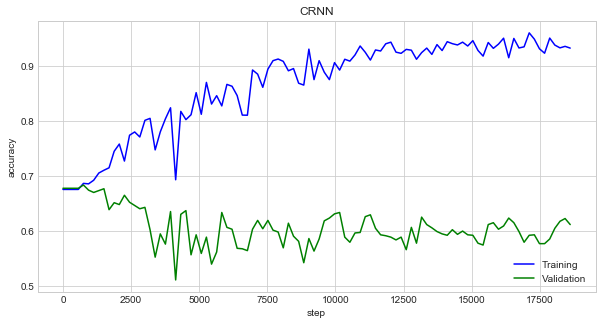

In [32]:
plt.figure(figsize=(10,5))
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('CRNN')
plt.show()

---
## 이건 vanilla CNN

In [204]:
tf.reset_default_graph()
tf.set_random_seed(777)  # reproducibility

# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# hyper parameters
learning_rate = 0.001
batch_size = 50
epoch = 200

# input place holders
X = tf.placeholder(tf.float32, [None, 26*24])
Y = tf.placeholder(tf.float32, [None, 2])
X_img = tf.reshape(X, [-1, 26, 24, 1])   # img 26x24x1 (black/white)

# L1 ImgIn shape=(?, 26, 24, 1)
W1 = tf.Variable(tf.random_normal([3, 24, 1, 32], stddev=0.01))
#    Conv     -> (?, 26, 1, 32)
#    Pool     -> (?, 13, 12, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='VALID')
L1 = tf.nn.relu(L1)
# L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
#                     strides=[1, 2, 2, 1], padding='SAME')
'''
Tensor("Conv2D:0", shape=(?, 26, 24, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 26, 24, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 13, 12, 32), dtype=float32)
'''

# # L2 ImgIn shape=(?, 13, 12, 32)
# W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
# #    Conv      ->(?, 13, 12, 64)
# #    Pool      ->(?, 7, 6, 64)
# L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
# L2 = tf.nn.relu(L2)
# L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
#                     strides=[1, 2, 2, 1], padding='SAME')
L2_flat = tf.reshape(L1, [-1, 1 * (26-2) * 32])
'''
Tensor("Conv2D_1:0", shape=(?, 13, 12, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 13, 12, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 6, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

# Final FC 7x6x64 inputs -> 2 outputs
W3 = tf.get_variable("W3", shape=[1*(26-2)*32, 2],
                     initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([2]))

# logits = tf.matmul(L2_flat, W3) + b
# # define cost/loss & optimizer
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#     logits=logits, labels=Y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

hypothesis = tf.nn.softmax(tf.matmul(L2_flat, W3)+b)
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), axis=1))
# train_step = tf.train.GradientDescentOptimizer(learning_rate= learning_rate).minimize(cost)
train_step = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)

predicted = tf.argmax(hypothesis, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

total_iter = epoch*int(X_train.shape[0]/batch_size) # 총 학습횟수
print('total iteration:', total_iter, '...')

total iteration: 18800 ...


In [205]:
s_time = time.time()
#----------------------
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
batch = getMiniBatch(X_train, Y_train, batch_size)

for i in range(total_iter):
    X_, Y_ = next(batch) # 미니배치 할당
#     pprint(X_.iloc[0,:5])
    train_step.run(feed_dict={X:X_, Y:Y_})
#     train_step.run(feed_dict={X:X_train, Y:Y_train})

#         아래 프린트용
    if i % int(total_iter/100) == 0:   
        train_accuracy = accuracy.eval(feed_dict={X:X_train, Y:Y_train})
        val_accuracy = accuracy.eval(feed_dict={X:X_test, Y:Y_test})
        cost_ = cost.eval(feed_dict={X:X_test, Y:Y_test})
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        x_range.append(i)

        print('step %d: acc_tr %g, acc_tt %g, cost %g' % (i, train_accuracy, val_accuracy, cost_))
# -------------------------
e_time = time.time()
print('%s sec' %(e_time - s_time))

step 0: acc_tr 0.675824, acc_tt 0.677937, cost 0.687507
step 188: acc_tr 0.678994, acc_tt 0.683009, cost 0.625114
step 376: acc_tr 0.677092, acc_tt 0.687236, cost 0.626634
step 564: acc_tr 0.676036, acc_tt 0.6847, cost 0.622884
step 752: acc_tr 0.670118, acc_tt 0.678783, cost 0.622289
step 940: acc_tr 0.674556, acc_tt 0.683009, cost 0.619084
step 1128: acc_tr 0.679628, acc_tt 0.685545, cost 0.608326
step 1316: acc_tr 0.680473, acc_tt 0.688081, cost 0.609123
step 1504: acc_tr 0.677303, acc_tt 0.681319, cost 0.608177
step 1692: acc_tr 0.678783, acc_tt 0.682164, cost 0.608705
step 1880: acc_tr 0.678149, acc_tt 0.681319, cost 0.613575
step 2068: acc_tr 0.676881, acc_tt 0.680473, cost 0.6138
step 2256: acc_tr 0.67836, acc_tt 0.681319, cost 0.614666
step 2444: acc_tr 0.680685, acc_tt 0.683855, cost 0.610838
step 2632: acc_tr 0.681741, acc_tt 0.686391, cost 0.610388
step 2820: acc_tr 0.681319, acc_tt 0.681319, cost 0.608064
step 3008: acc_tr 0.683009, acc_tt 0.67202, cost 0.612283
step 3196: 

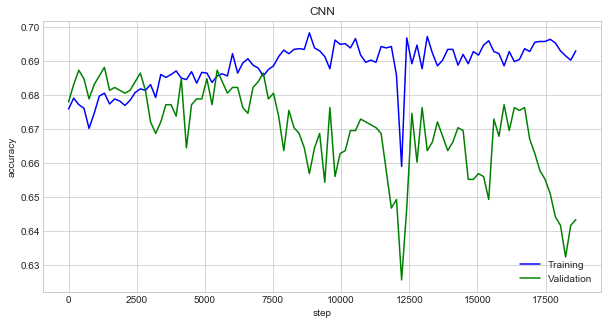

In [206]:
plt.figure(figsize=(10,5))
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('CNN')
plt.show()

---
### 여기는 many to one RNN

In [225]:
tf.reset_default_graph()
# train Parameters
seq_length = 26
data_dim = 24
hidden_dim = 24
output_dim = 2
learning_rate = 0.001
epoch = 400
batch_size = 200

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length*data_dim])
X_re = tf.reshape(X, [-1, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, output_dim])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)#, activation=tf.nn.relu)
cell = tf.contrib.rnn.MultiRNNCell([cell]*2, state_is_tuple=True) # multiple layers
outputs, _states = tf.nn.dynamic_rnn(cell, X_re, dtype=tf.float32)

# Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output
fc1 = tf.contrib.layers.fully_connected(outputs[:, -1], 24, activation_fn=tf.nn.relu)  # We use the last cell's output
Y_pred = tf.contrib.layers.fully_connected(fc1, output_dim, activation_fn=None)  # We use the last cell's output

hypothesis = tf.nn.softmax(Y_pred)

# cost/loss
# cost = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), axis=1))
# weights = tf.ones([batch_size, seq_length])
# sequence_loss = tf.contrib.seq2seq.sequence_loss(
#     logits=Y_pred, targets=Y, weights=weights)
# cost = tf.reduce_mean(sequence_loss)
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cost)

# prediction
predicted = tf.argmax(hypothesis, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

total_iter = epoch*int(X_train.shape[0]/batch_size) # 총 학습횟수
print('total iteration:', total_iter, '...')

total iteration: 9200 ...


In [226]:
s_time = time.time()
#----------------------
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
batch = getMiniBatch(X_train, Y_train, batch_size)

for i in range(total_iter):
    X_, Y_ = next(batch) # 미니배치 할당
#     pprint(X_.iloc[0,:5])
    train_step.run(feed_dict={X:X_, Y:Y_})
#     train_step.run(feed_dict={X:X_train, Y:Y_train})

#         아래 프린트용
    if i % int(total_iter/100) == 0:   
        train_accuracy = accuracy.eval(feed_dict={X:X_train, Y:Y_train})
        val_accuracy = accuracy.eval(feed_dict={X:X_test, Y:Y_test})
        cost_ = cost.eval(feed_dict={X:X_test, Y:Y_test})
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        x_range.append(i)

        print('step %d: acc_tr %g, acc_tt %g, cost %g' % (i, train_accuracy, val_accuracy, cost_))
# -------------------------
e_time = time.time()
print('%s sec' %(e_time - s_time))

step 0: acc_tr 0.325655, acc_tt 0.322063, cost 0.708172
step 92: acc_tr 0.675824, acc_tt 0.677937, cost 0.624272
step 184: acc_tr 0.675824, acc_tt 0.677937, cost 0.622114
step 276: acc_tr 0.675824, acc_tt 0.677937, cost 0.615001
step 368: acc_tr 0.675824, acc_tt 0.677937, cost 0.61442
step 460: acc_tr 0.675824, acc_tt 0.677937, cost 0.610383
step 552: acc_tr 0.677937, acc_tt 0.683855, cost 0.609183
step 644: acc_tr 0.679205, acc_tt 0.6847, cost 0.608704
step 736: acc_tr 0.680685, acc_tt 0.685545, cost 0.609631
step 828: acc_tr 0.682164, acc_tt 0.688081, cost 0.608062
step 920: acc_tr 0.682375, acc_tt 0.687236, cost 0.606806
step 1012: acc_tr 0.686179, acc_tt 0.688926, cost 0.604886
step 1104: acc_tr 0.68787, acc_tt 0.688081, cost 0.603586
step 1196: acc_tr 0.68956, acc_tt 0.692308, cost 0.602635
step 1288: acc_tr 0.68787, acc_tt 0.687236, cost 0.606121
step 1380: acc_tr 0.693787, acc_tt 0.682164, cost 0.603519
step 1472: acc_tr 0.693998, acc_tt 0.687236, cost 0.606069
step 1564: acc_tr

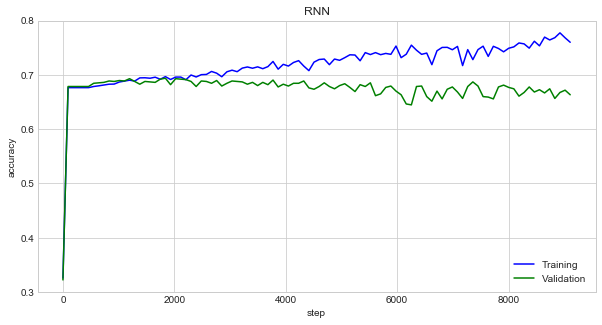

In [227]:
plt.figure(figsize=(10,5))
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('RNN')
plt.show()

---
## 아래는 그냥 FFN

In [219]:
# settings
LEARNING_RATE = 0.01
# epoch
EPOCH_MAX = 1000

#batch size는 Stochastic gradient descent(SGD)시에 데이터 몇개씩 훈련시킬지 
DROPOUT = 0.5
BATCH_SIZE = 200

#L2 regularization
ALPHA = 0.01

In [220]:
# Set tensorflow graph for Feedforward NN
tf.reset_default_graph()

# writer.flush()

num_label = 2
num_feature = 26*24

X = tf.placeholder(tf.float32, shape=[None, num_feature])
Y = tf.placeholder(tf.float32, shape=[None, num_label])
keep_prob = tf.placeholder(tf.float32)

# Xavier 초기화 하니 잘됨
# dropout잘 확인안됨, 데이터 노멀라이징 필요, cost자꾸 튐..
with tf.name_scope('LAYER1') as scope:
    W1 = tf.get_variable(name='weight1', shape=[num_feature, 500], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.random_normal([500]), name='bias1')
    L1 = tf.nn.tanh(tf.matmul(X, W1)+b1)
#     L1 = tf.nn.relu(tf.matmul(X, W1)+b1)
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

with tf.name_scope('LAYER2') as scope:
    W2 = tf.get_variable(name='weight2', shape=[500, 500], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.random_normal([500]), name='bias2')
    L2 = tf.nn.tanh(tf.matmul(L1, W2)+b2)
#     L2 = tf.nn.relu(tf.matmul(L1, W2)+b2)
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

with tf.name_scope('LAYER5') as scope:
    W5 = tf.get_variable(name='weight5', shape=[500, num_label], initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([num_label]), name='bias5')
    hypothesis = tf.nn.softmax(tf.matmul(L2, W5)+b5)
    # 마지막 레이어엔 당연히 dropout하면안됨

# Regularization: L2 ridge
regularzers = tf.nn.l2_loss(W1)
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), axis=1))
cost = tf.reduce_mean(cost+regularzers*ALPHA)

# cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), axis=1))
train_step = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

def setNN(opt_num=0):
    if(opt_num==0): train_step = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
    elif(opt_num==1): train_step = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
    elif(opt_num==2): train_step = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
    elif(opt_num==3): train_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

predicted = tf.argmax(hypothesis, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

#-----for tensorboard
# cost_summ = tf.summary.scalar('cost', cost)
# acc_summ = tf.summary.scalar('train_accuracy', accuracy)

# summary = tf.summary.merge_all()
# val_acc_summ = tf.summary.scalar('val_accuracy', accuracy)
#------------
total_iter = EPOCH_MAX*int(X_train.shape[0]/BATCH_SIZE) 
print(total_iter, 'times iterations')

23000 times iterations


In [222]:
# Definie session function for models
def execNN():
    s_time = time.time()
    #----------------------

    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    batch = getMiniBatch(X_train, Y_train, batch_size)
    
    x_range=[]
    train_accuracies=[]
    val_accuracies=[]
    # 약 11000번 반복
    for i in range(total_iter):
        batch_x, batch_y = next(batch)
        train_step.run(feed_dict={X: batch_x, Y: batch_y, keep_prob: DROPOUT})
#         train_step.run(feed_dict={X: X_train, Y: Y_train, keep_prob: 1})


        if i % 100 == 0:   
            train_accuracy = accuracy.eval(feed_dict={X:X_train, Y:Y_train, keep_prob: 1})
            val_accuracy = accuracy.eval(feed_dict={X: X_test, Y: Y_test, keep_prob: 1})
            cost_ = cost.eval(feed_dict={X:X_test, Y:Y_test, keep_prob: 1})

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            x_range.append(i)

            print('step %d: acc_tr %g, acc_tt %g, cost %g' % (i, train_accuracy, val_accuracy, cost_))
    #         writer.add_summary(s, i)
    #         writer.add_summary(val, i)

    # writer.close()
    # -------------------------
    e_time = time.time()

    # test data accuracy
    test_accuracy = accuracy.eval(feed_dict={X: X_test, Y: Y_test, keep_prob: 1})
    sess.close()
    print('test accuracy:',test_accuracy)
    print('%s sec' %(e_time - s_time))    
    return x_range, train_accuracies, val_accuracies, test_accuracy, e_time-s_time

In [223]:
# execute models
# Regularizer - dropout 0.5
y_trains=[]
y_vals=[]
test_accs=[]
durs=[]
for i in range(1):
    setNN(i)
    x_range, y_train, y_val, test_acc, dur = execNN()
    y_trains.append(y_train)
    y_vals.append(y_val)
    test_accs.append(test_acc)
    durs.append(dur)

step 0: acc_tr 0.675824, acc_tt 0.677937, cost 3.43078
step 100: acc_tr 0.676036, acc_tt 0.677092, cost 3.34562
step 200: acc_tr 0.675824, acc_tt 0.677937, cost 3.30785
step 300: acc_tr 0.680262, acc_tt 0.683855, cost 3.25185
step 400: acc_tr 0.675824, acc_tt 0.677937, cost 3.18765
step 500: acc_tr 0.675824, acc_tt 0.677937, cost 3.14434
step 600: acc_tr 0.675824, acc_tt 0.677937, cost 3.09062
step 700: acc_tr 0.676458, acc_tt 0.680473, cost 3.0395
step 800: acc_tr 0.675824, acc_tt 0.677937, cost 2.98923
step 900: acc_tr 0.676036, acc_tt 0.677937, cost 2.94112
step 1000: acc_tr 0.675824, acc_tt 0.677937, cost 2.90053
step 1100: acc_tr 0.675824, acc_tt 0.677937, cost 2.84952
step 1200: acc_tr 0.675824, acc_tt 0.677937, cost 2.80538
step 1300: acc_tr 0.679417, acc_tt 0.681319, cost 2.76814
step 1400: acc_tr 0.675824, acc_tt 0.677937, cost 2.72529
step 1500: acc_tr 0.676669, acc_tt 0.679628, cost 2.6774
step 1600: acc_tr 0.676881, acc_tt 0.681319, cost 2.63699
step 1700: acc_tr 0.682375, 

step 14100: acc_tr 0.680896, acc_tt 0.683009, cost 0.782709
step 14200: acc_tr 0.683221, acc_tt 0.680473, cost 0.77839
step 14300: acc_tr 0.67836, acc_tt 0.681319, cost 0.781941
step 14400: acc_tr 0.683221, acc_tt 0.678783, cost 0.769533
step 14500: acc_tr 0.684911, acc_tt 0.677092, cost 0.767531
step 14600: acc_tr 0.679628, acc_tt 0.688926, cost 0.773618
step 14700: acc_tr 0.681319, acc_tt 0.683009, cost 0.766154
step 14800: acc_tr 0.682798, acc_tt 0.677937, cost 0.757726
step 14900: acc_tr 0.68153, acc_tt 0.678783, cost 0.754174
step 15000: acc_tr 0.677092, acc_tt 0.688081, cost 0.760426
step 15100: acc_tr 0.683643, acc_tt 0.680473, cost 0.750453
step 15200: acc_tr 0.680685, acc_tt 0.683009, cost 0.757936
step 15300: acc_tr 0.683855, acc_tt 0.677937, cost 0.743268
step 15400: acc_tr 0.682164, acc_tt 0.680473, cost 0.740516
step 15500: acc_tr 0.680473, acc_tt 0.686391, cost 0.744872
step 15600: acc_tr 0.678994, acc_tt 0.682164, cost 0.736763
step 15700: acc_tr 0.680685, acc_tt 0.68300

IndexError: list index out of range

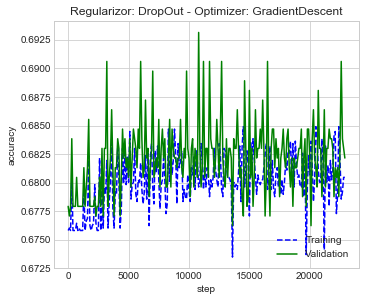

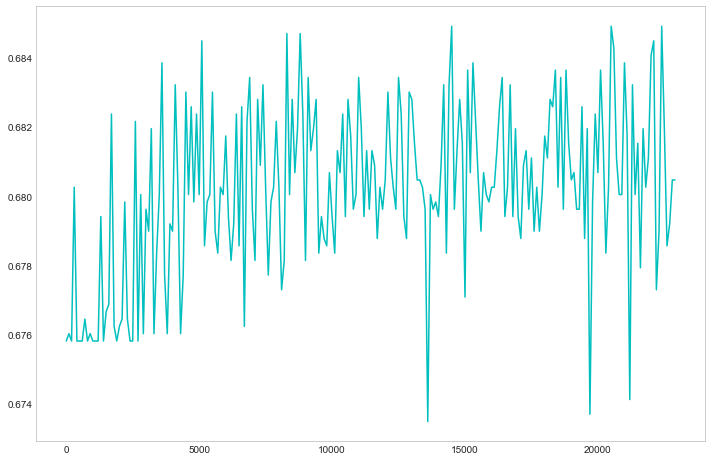

In [224]:
titles = ['GradientDescent','Adagrad','RMSProp','Adam']
colors = ['c','m','y','k']
# print("네가지 Optimizer에 따른 Dropout효과의 비교")
plt.figure(figsize=(12,10))
for i in range(1):
    plt.grid()
    plt.subplot(221+i)
    plt.plot(x_range, y_trains[i],'--b', label='Training')
    plt.plot(x_range, y_vals[i],'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    # plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.title('Regularizor: DropOut - Optimizer: '+titles[i])
    
plt.figure(figsize=(12,8))
plt.grid()
for i in range(4):
    plt.plot(x_range, y_trains[i],'-'+colors[i], label=titles[i])
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('train_accuracy')
plt.xlabel('step')
plt.title(u'Compare Dropout by the Each Optimizer')

print('트레이닝 시간(sec)', durs)
print('테스트셋 정확도(%)', [i*100 for i in test_accs])